In [37]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,KFold
from collections import OrderedDict
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [27]:
train = pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [4]:
train.head()

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,type2,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,type2,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,...,type2,1.0,4,-0.9612,-0.4537,3.0,3,8,3,0.0851
3,EID_17492,F,26.0,3,Single,Lebanon,Human Resource Management,Behavioral,4.0,3,...,type2,1.0,3,-1.8176,-0.4537,NaN,3,7,3,0.0668
4,EID_22534,F,31.0,1,Married,Springfield,Logistics,Conceptual,5.0,4,...,type3,3.0,1,0.7516,-0.4537,2.0,2,8,2,0.1827


In [5]:
print("shape of training set: ",train.shape)
print("shape of testing set: ",test.shape)

shape of training set:  (7000, 24)
shape of testing set:  (3000, 23)


# Null Handling

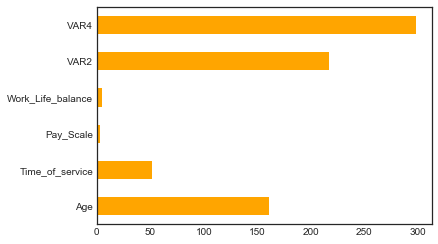

In [6]:
test.isnull().sum()[test.isnull().sum()!=0].plot(kind='barh',color='orange')

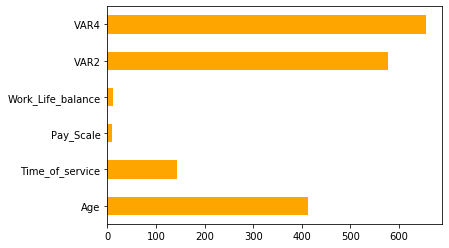

In [64]:
train.isnull().sum()[train.isnull().sum()!=0].plot(kind='barh',color='orange')

In [65]:
train[['Age','Time_of_service','Pay_Scale','Work_Life_balance','VAR2','VAR4']].skew()

Age                  0.243487
Time_of_service      0.800375
Pay_Scale           -0.259976
Work_Life_balance    0.194342
VAR2                -0.428420
VAR4                -0.108307
dtype: float64

In [70]:
df=train[['Age','Time_of_service']].dropna()

X=np.array(df['Time_of_service'])
y=np.array(df['Age'])

model=LinearRegression()
model.fit(X.reshape(-1, 1),y.reshape(-1, 1))

y_pred=model.predict(X.reshape(-1, 1))
r2_score(y,y_pred)
print(model.coef_)
print(model.intercept_)

[[1.20551006]]
[23.42666405]


In [9]:
df=train[['Age','Time_of_service']].dropna()
df
X=np.array(df['Age'])
y=np.array(df['Time_of_service'])

model=LinearRegression()
model.fit(X.reshape(-1, 1),y.reshape(-1, 1))

y_pred=model.predict(X.reshape(-1, 1))
r2_score(y,y_pred)
print(model.coef_)
print(model.intercept_)

[[0.70035976]]
[-14.3211053]


In [10]:
# x=np.array(train['Age'][train.Time_of_service.isna()])
# train['Time_of_service'][train.Time_of_service.isna()]=model.predict(X.reshape(-1, 1))

train['Time_of_service'][train.Time_of_service.isna()]=train['Age'].apply(lambda x: 0.7*x-14.32)
test['Time_of_service'][test.Time_of_service.isna()]=test['Age'].apply(lambda x: 0.7*x-14.32)

train['Age'][train.Age.isna()]=train['Time_of_service'].apply(lambda x: 1.209*x+23.38)
test['Age'][test.Age.isna()]=test['Time_of_service'].apply(lambda x: 1.209*x+23.38)

In [11]:
#train data
train['Age'].fillna(train['Age'].mean(),inplace=True)
train['VAR2'].fillna(method='ffill',inplace=True)
train['VAR4'].fillna(method='ffill',inplace=True)      
train['Time_of_service'].fillna(train['Time_of_service'].median(),inplace=True)
train['Pay_Scale'].fillna(train['Pay_Scale'].mode()[0],inplace=True)
train['Work_Life_balance'].fillna(train['Work_Life_balance'].mode()[0],inplace=True)


#test data
test['Age'][train.Time_of_service.isnull()].fillna(test['Age'].mean(),inplace=True)
test['VAR2'].fillna(method='ffill',inplace=True)
test['VAR4'].fillna(method='ffill',inplace=True)      
test['Time_of_service'].fillna(test['Time_of_service'].median(),inplace=True)
test['Pay_Scale'].fillna(test['Pay_Scale'].mode()[0],inplace=True)
test['Work_Life_balance'].fillna(test['Work_Life_balance'].mode()[0],inplace=True)

# EDA

In [28]:
train.drop('Employee_ID',axis=1,inplace=True)
test.drop('Employee_ID',axis=1,inplace=True)

In [29]:
mask=['Education_Level', 'Time_since_promotion','Travel_Rate', 'Post_Level', 'Pay_Scale','Work_Life_balance',
                      'VAR1','VAR2','VAR3','VAR4','VAR5', 'VAR6','VAR7']
train[mask]=train[mask].astype('object',inplace=True)
test[mask]=test[mask].astype('object',inplace=True)

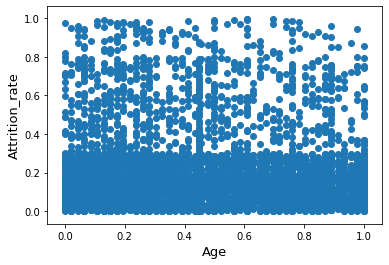

Corr: [[ 1.         -0.01508594]
 [-0.01508594  1.        ]]


In [73]:
import numpy as np
scaler=MinMaxScaler()
age=np.array(train['Age'])
age=scaler.fit_transform(age.reshape(-1, 1))
fig, ax=plt.subplots()
ax.scatter(x=age,y=train['Attrition_rate'])
plt.ylabel('Attrition_rate', fontsize=13)
plt.xlabel('Age', fontsize=13)
plt.show()
print("Corr:",np.corrcoef(train['Age'], train['Attrition_rate']))


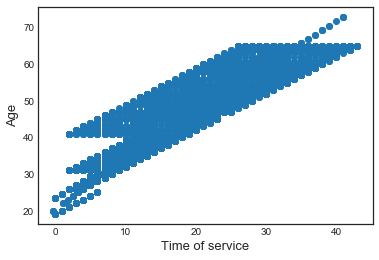

Corr: [[1.         0.92419325]
 [0.92419325 1.        ]]


In [9]:
fig, ax = plt.subplots()
ax.scatter(x=train['Time_of_service'],y=train['Age'])
plt.ylabel('Age', fontsize=13)
plt.xlabel('Time of service', fontsize=13)
plt.show()
print("Corr:",np.corrcoef(train['Time_of_service'], train['Age']))

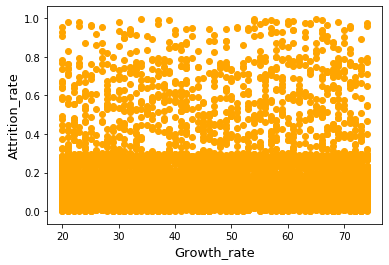

Corr: [[1.         0.01424654]
 [0.01424654 1.        ]]


In [70]:
fig, ax = plt.subplots()
ax.scatter(x=train['growth_rate'],y=train['Attrition_rate'],color='orange')
plt.ylabel('Attrition_rate', fontsize=13)
plt.xlabel('Growth_rate', fontsize=13)
plt.show()
print("Corr:",np.corrcoef(train['growth_rate'], train['Attrition_rate']))

In [61]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y


 mu = 13.41 and sigma = 10.34



Text(0.5, 1.0, 'Age distribution')

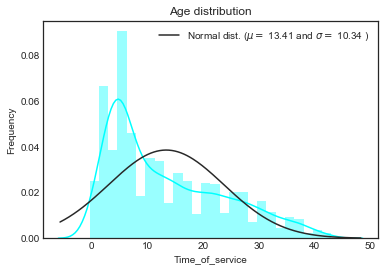

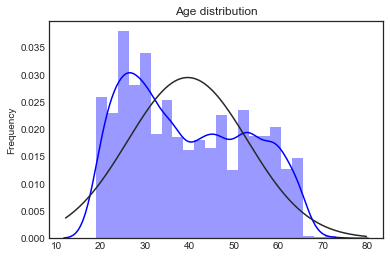

In [59]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
sns.distplot(train['Time_of_service'] , fit=norm,color='Aqua');

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Time_of_service'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Age distribution')



fig = plt.figure()
x=np.array(train['Age'])
y=np.log1p(x)
sns.distplot(x, fit=norm,color='blue')
plt.ylabel('Frequency')
plt.title('Age distribution')


 mu = 3.65 and sigma = 0.34


 mu = 0.66 and sigma = 0.20



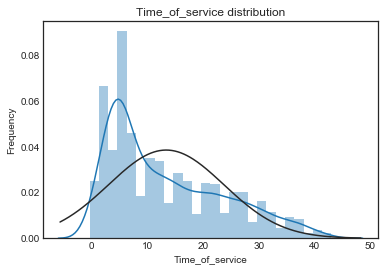

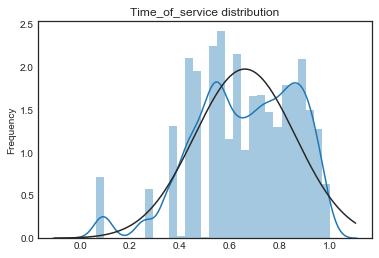

In [60]:
# since data is rightly skewed we are log transforming the data 

sns.distplot(train['Time_of_service'],fit=norm)
plt.ylabel('Frequency')
plt.title('Time_of_service distribution')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))



x=np.array(train['Time_of_service'])
y=normalize(np.log1p(x))

# lets check the new distribution
fig = plt.figure()
sns.distplot(y,fit=norm)
plt.ylabel('Frequency')
plt.title('Time_of_service distribution')
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))




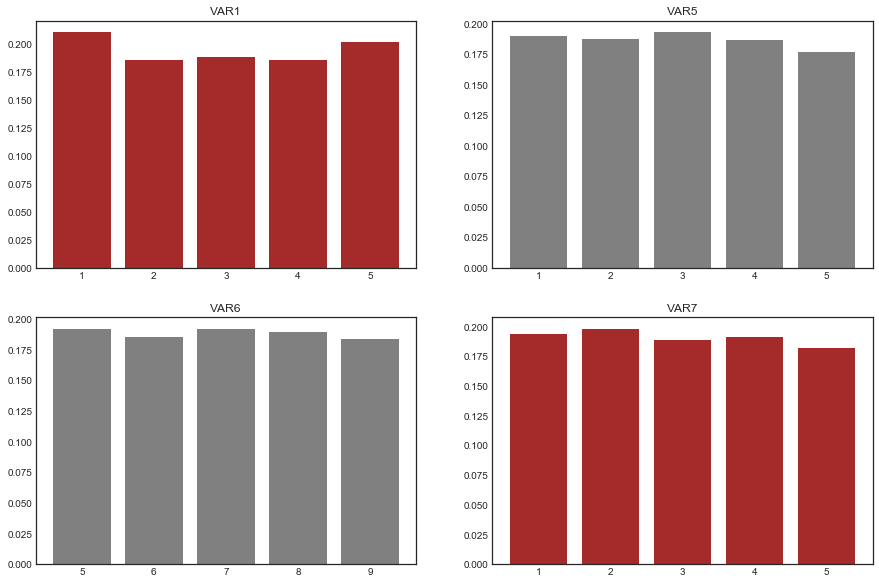

In [125]:
cat=['VAR1', 'VAR5', 'VAR6','VAR7']
fig,ax= plt.subplots(2,2,figsize=(15,10))
color=['brown','grey','grey','brown']
z=0
for i in range(0,2):
    for j in range(0,2):
        df=train.groupby(cat[z]).agg({'Attrition_rate':'mean'})
        df.reset_index(inplace=True)
        ax[i,j].bar(df[cat[z]],df['Attrition_rate'],color=color[z])
        ax[i,j].set_title(cat[z])
        z=z+1

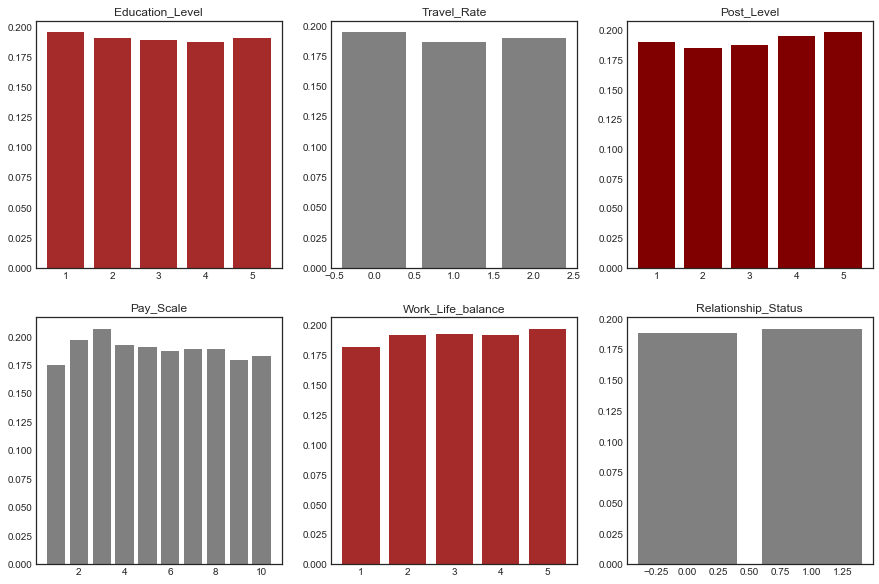

In [155]:
cat=['Education_Level', 'Travel_Rate', 'Post_Level', 'Pay_Scale','Work_Life_balance','Relationship_Status']
fig,ax= plt.subplots(2,3,figsize=(15,10))
color=['brown','grey','maroon','grey','brown','grey']
z=0
for i in range(0,2):
    for j in range(0,3):
        df=train.groupby(cat[z]).agg({'Attrition_rate':'mean'})
        df.reset_index(inplace=True)
        ax[i,j].bar(df[cat[z]],df['Attrition_rate'],color=color[z])
        ax[i,j].set_title(cat[z])
        z=z+1



Text(0.5, 1.0, 'Compensation_and_Benefits')

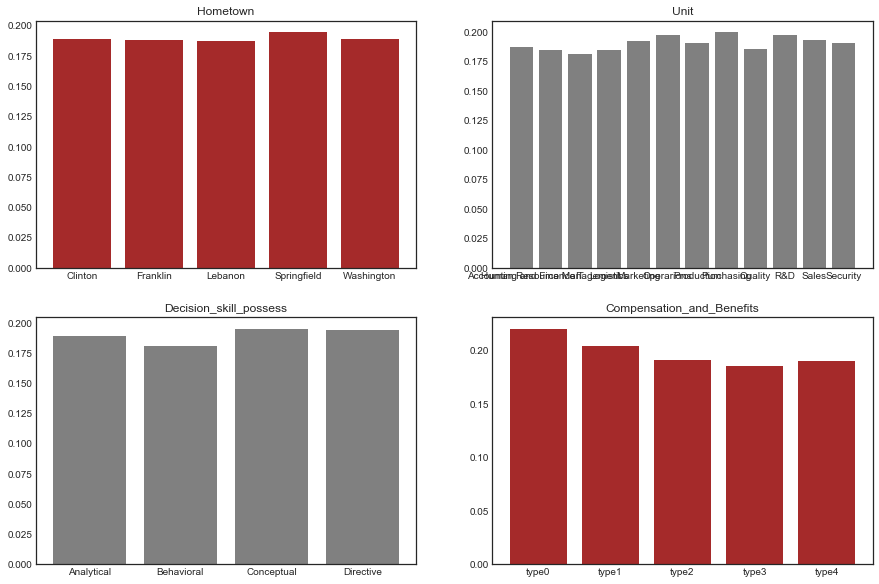

In [112]:
fig,ax= plt.subplots(2,2,figsize=(15,10))
color=['brown','grey','grey','brown']

Hometown=train.groupby('Hometown').agg({'Attrition_rate':'mean'})
Hometown.reset_index(inplace=True)
ax[0,0].bar(Hometown['Hometown'],Hometown['Attrition_rate'],color=color[0])
ax[0,0].set_title('Hometown')

Unit=train.groupby('Unit').agg({'Attrition_rate':'mean'})
Unit.reset_index(inplace=True)
ax[0,1].bar(Unit['Unit'],Unit['Attrition_rate'],color=color[1])
ax[0,1].set_title('Unit')

skill=train.groupby('Decision_skill_possess').agg({'Attrition_rate':'mean'})
skill.reset_index(inplace=True)
ax[1,0].bar(skill['Decision_skill_possess'],skill['Attrition_rate'],color=color[2])
ax[1,0].set_title('Decision_skill_possess')

CB=train.groupby('Compensation_and_Benefits').agg({'Attrition_rate':'mean'})
CB.reset_index(inplace=True)
ax[1,1].bar(CB['Compensation_and_Benefits'],CB['Attrition_rate'],color=color[3])
ax[1,1].set_title('Compensation_and_Benefits')


## Labelling binominal variables

In [30]:
Num_val={'M':0,'F':1}
train['Gender']=train['Gender'].apply(lambda x: Num_val[x])

Rel_val={'Married':0,'Single':1}
train['Relationship_Status']=train['Relationship_Status'].apply(lambda x: Rel_val[x])

In [31]:
Num_val={'M':0,'F':1}
test['Gender']=test['Gender'].apply(lambda x: Num_val[x])

Rel_val={'Married':0,'Single':1}
test['Relationship_Status']=test['Relationship_Status'].apply(lambda x: Rel_val[x])

## Labeling Categorial variables

In [32]:
Unneccesary_columns=['Education_Level_5','Time_since_promotion_0','Travel_Rate_2','Post_Level_5','Pay_Scale_1.0',
                     'Work_Life_balance_5.0','Unit_Security','Hometown_Clinton','Decision_skill_possess_Directive',
                     'Compensation_and_Benefits_type1','VAR1_1','VAR2_1.6081','VAR3_-2.7762','VAR4_3.0','VAR5_5',
                     'VAR6_9','VAR7_1']

numeric_feats=['Time_of_service']
train[numeric_feats] = np.log1p(train[numeric_feats])
test[numeric_feats]=np.log1p(test[numeric_feats])

train=pd.get_dummies(train)
test=pd.get_dummies(test)

In [33]:
print("training data shape: ",train.shape)
print("Test data shape: ",test.shape)

training data shape:  (7000, 98)
Test data shape:  (3000, 97)


In [34]:
train_xg=train.drop(Unneccesary_columns,axis=1)
test_xg=test.drop(Unneccesary_columns,axis=1)
print("Training data shape: ",train_xg.shape)
print("Test data shape: ",test_xg.shape)

Training data shape:  (7000, 81)
Test data shape:  (3000, 80)


# Feature Extraction

In [38]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [39]:
X_train= train_xg.drop(['Attrition_rate'],axis=1)
y_train=train_xg['Attrition_rate']
model.fit(X_train,y_train)
y_pred=model.predict(X_train)

print(r2_score(train_xg['Attrition_rate'],y_pred))

0.9605130768046453


In [40]:
OrderedDict(sorted(model.get_booster().get_score(importance_type='weight').items(), key=lambda t: t[1], reverse=True))

OrderedDict([('growth_rate', 19513),
             ('Age', 19195),
             ('Time_of_service', 17479),
             ('VAR4_2.0', 2508),
             ('Relationship_Status', 2505),
             ('VAR1_3', 2455),
             ('VAR2_-0.1048', 2419),
             ('Gender', 2412),
             ('Decision_skill_possess_Behavioral', 2405),
             ('Hometown_Lebanon', 2400),
             ('Travel_Rate_0', 2399),
             ('Unit_Logistics', 2355),
             ('VAR6_6', 2354),
             ('Work_Life_balance_1.0', 2338),
             ('VAR4_1.0', 2329),
             ('VAR6_7', 2328),
             ('VAR7_3', 2318),
             ('Unit_IT', 2304),
             ('VAR2_0.7516', 2299),
             ('Decision_skill_possess_Analytical', 2296),
             ('Post_Level_2', 2293),
             ('Hometown_Franklin', 2287),
             ('VAR1_4', 2280),
             ('Time_since_promotion_2', 2275),
             ('Pay_Scale_8.0', 2273),
             ('Pay_Scale_6.0', 2270),
          

In [41]:
most_relevant_features= list( dict((k, v) for k, v in model.get_booster().get_score(importance_type='weight').items()
                                   if v >= 2200).keys())
print(len(most_relevant_features))

41


# Model

In [43]:
#train_x=np.array(X[most_relevant_features])
#train_y=np.array(train['Attrition_rate'])

#for tuning parameters
#parameters_for_testing = {
   #'learning_rate':[i/100 for i in range(1,15,2)]
   #'subsample':[i/10.0 for i in range(6,10)],
   #'colsample_bytree':[0.5,0.6],
   #'gamma':[0.04,0.06,0.1],
   #'max_depth':range(3,10,2),
   #'min_child_weight':range(1,6,2)
   #'reg_alpha':[1e-5, 1e-2],
   #'reg_lambda':[1e-5, 1e-2, 0.45] }

                    
#xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=10000, max_depth=9,
#    min_child_weight=1.5, gamma=0.05, subsample=0.6, colsample_bytree=0.4, nthread=6, scale_pos_weight=1, seed=27)

#gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing,cv=3, n_jobs=-1,iid=False, verbose=10,scoring='neg_mean_squared_error')
#gsearch1.fit(train_x,train_y)
#print (gsearch1.grid_scores_)
#print('best params')
#print (gsearch1.best_params_)
#print('best score')
#print (gsearch1.best_score_)



In [45]:
model1 = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,              
                 learning_rate=0.06,
                 max_depth=11, 
                 min_child_weight=1.5,     
                 n_estimators=70,                                                                    
                 subsample=0.8,
                 nthread=6,
                 reg_lambda=1e-5 ,  
                 reg_alpha=1e-5,
                 scale_pos_weight=1,
                 seed=27) 

In [46]:
model1.fit(X_train[most_relevant_features],y_train)
y_pred=model1.predict(X_train[most_relevant_features])
print("Train_r2:",r2_score(y_train,y_pred))

Train_r2: 0.8093548207147263


In [47]:
y_pred_test=model1.predict(test_xg[most_relevant_features])
test_submit=pd.read_csv("test.csv")

submission=pd.DataFrame(zip(test_submit['Employee_ID'],y_pred_test))
submission.rename(columns={0:'Employee_ID',
                         1:'Attrition_rate'},inplace=True)

submission.to_csv("submission.csv",index=False)
submission.head()

,Employee_ID,Attrition_rate
0,EID_22713,0.276538
1,EID_9658,0.274005
2,EID_22203,0.210611
3,EID_7652,0.196277
4,EID_6516,0.229817
